# Spam Detection NLP Project

## Setup

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

from collections import Counter

nltk.download('stopwords')
from nltk.corpus import stopwords

from utils.preprocessing import clean_text
from utils.eda import plot_message_lengths, plot_top_words_by_class, plot_venn_words
from utils.baseline import run_baseline_model
from utils.mnb import run_multinomial_nb_model
from utils.lstm import run_lstm_model
from utils.bert import run_bert_model
from utils.csv import write_stats_to_csv


2025-06-04 03:00:44.362352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 03:00:44.369584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749027644.377193   56202 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749027644.379564   56202 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749027644.385924   56202 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Dataset


In [3]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', names=["label", "message"])

df.head()
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Pre-Processing

#### Remove Stop-Words

In [4]:
VARIANTS = ['raw', 'normalized', 'stop', 'stop_lemma', 'stop_stem']
df['raw'] = df['message']
df['normalized'] = df['message'].apply(lambda x: clean_text(x, 'normalized'))
df['stop'] = df['message'].apply(lambda x: clean_text(x, 'stop'))
df['stop_lemma'] = df['message'].apply(lambda x: clean_text(x, 'stop_lemma'))
df['stop_stem'] = df['message'].apply(lambda x: clean_text(x, 'stop_stem'))


# Print examples where all variants are different
print("\nExamples where all variants are different:")
different_variants = []

for idx, row in df.iterrows():
    variants = [row[variant] for variant in VARIANTS]
    # Check if all variants are different from each other
    if len(set(variants)) == len(VARIANTS):
        different_variants.append({
            'message': row['message'],
            'normalized': row['normalized'],
            'stop': row['stop'],
            'stop_lemma': row['stop_lemma'],
            'stop_stem': row['stop_stem'],
            'label': row['label']
        })
        # Limit to 5 examples to avoid overwhelming output
        if len(different_variants) >= 5:
            break

# Display the examples in a formatted way
for i, example in enumerate(different_variants, 1):
    print(f"\nExample {i} ({example['label']}):")
    print(f"Original: {example['message']}")
    print(f"Normalized:      {example['normalized']}")
    print(f"Stop:     {example['stop']}")
    print(f"Lemma:    {example['stop_lemma']}")
    print(f"Stem:     {example['stop_stem']}")



Examples where all variants are different:

Example 1 (ham):
Original: Nah I don't think he goes to usf, he lives around here though
Normalized:      nah i dont think he goes to usf he lives around here though
Stop:     nah dont think goes usf lives around though
Lemma:    nah dont think go usf life around though
Stem:     nah dont think goe usf live around though

Example 2 (spam):
Original: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Normalized:      freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send 150 to rcv
Stop:     freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send 150 rcv
Lemma:    freemsg hey darling 3 week word back id like fun still tb ok xxx std chgs send 150 rcv
Stem:     freemsg hey darl 3 week word back id like fun still tb ok xxx std chg send 150 rcv

Example 3 

## EDA

Saved plot to data/eda/raw/message_lengths.png
Saved plot to data/eda/raw/top_spam.png
Saved plot to data/eda/raw/top_spam.png
Saved plot to data/eda/raw/top_ham.png
Saved plot to data/eda/raw/top_ham.png
Saved plot to data/eda/raw/venn.png
Saved plot to data/eda/normalized/message_lengths.png
Saved plot to data/eda/normalized/top_spam.png
Saved plot to data/eda/normalized/top_spam.png
Saved plot to data/eda/normalized/top_ham.png
Saved plot to data/eda/normalized/top_ham.png
Saved plot to data/eda/normalized/venn.png
Saved plot to data/eda/stop/message_lengths.png
Saved plot to data/eda/stop/top_spam.png
Saved plot to data/eda/stop/top_spam.png
Saved plot to data/eda/stop/top_ham.png
Saved plot to data/eda/stop/top_ham.png
Saved plot to data/eda/stop/venn.png
Saved plot to data/eda/stop_lemma/message_lengths.png
Saved plot to data/eda/stop_lemma/top_spam.png
Saved plot to data/eda/stop_lemma/top_spam.png
Saved plot to data/eda/stop_lemma/top_ham.png
Saved plot to data/eda/stop_lemma/t

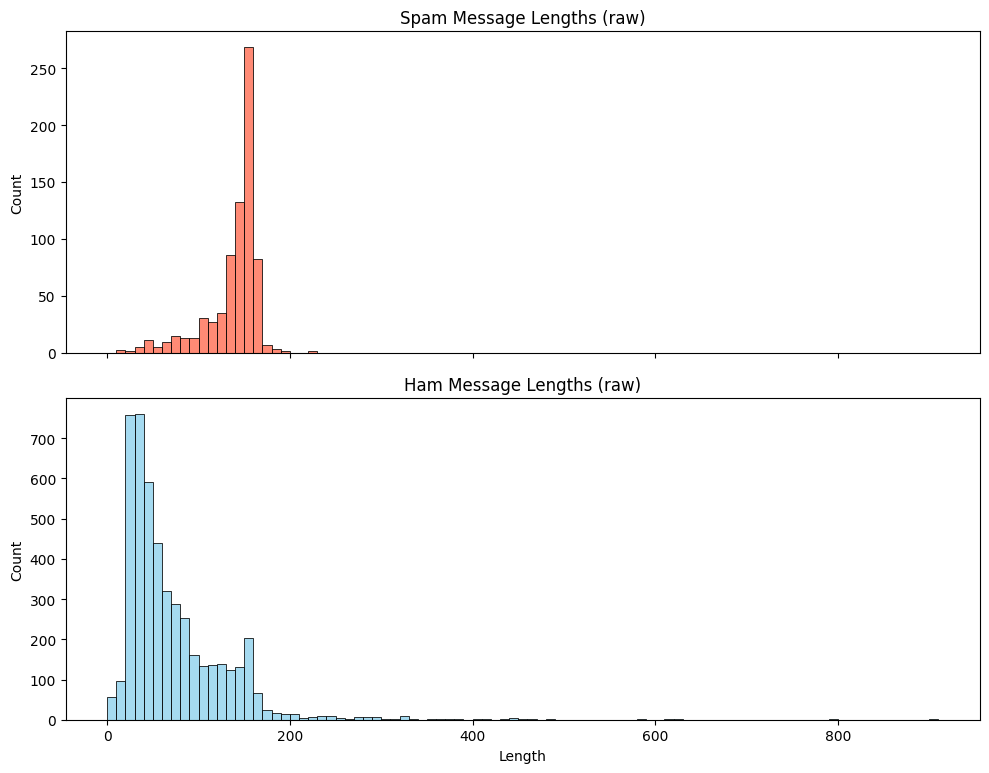

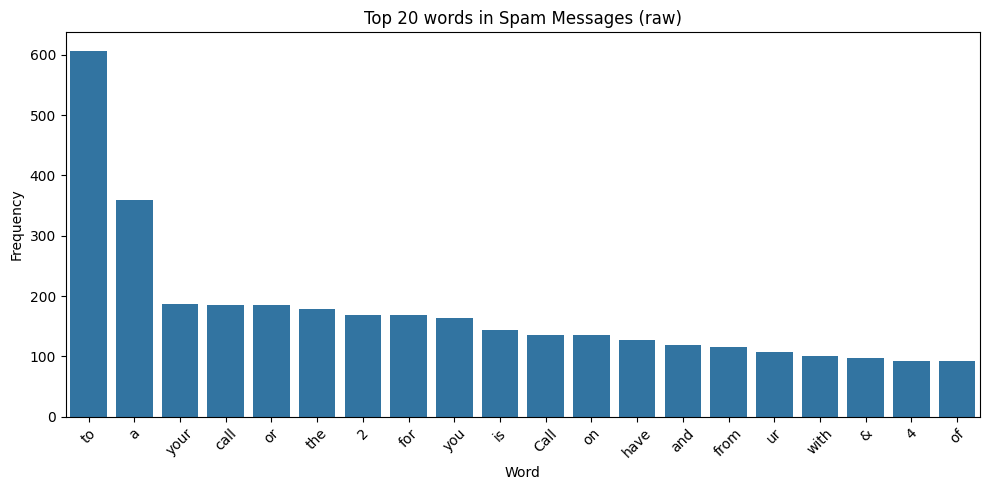

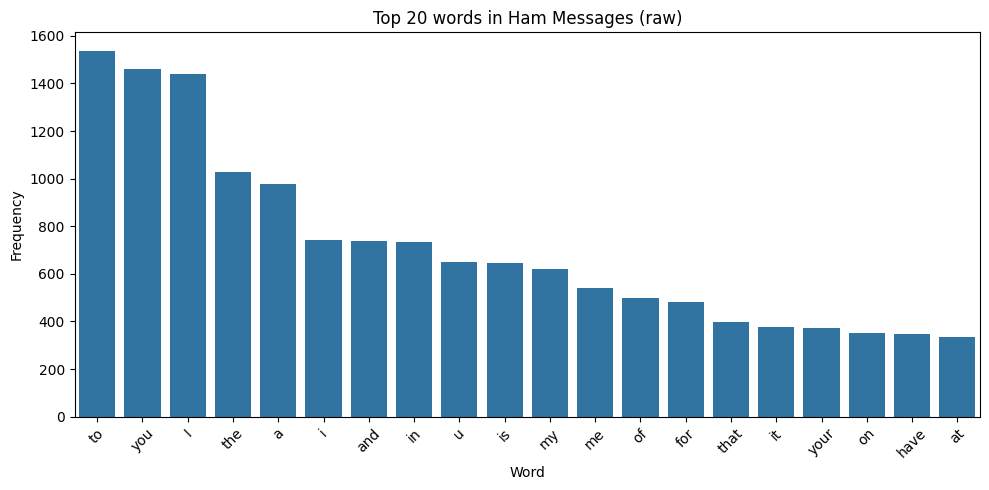

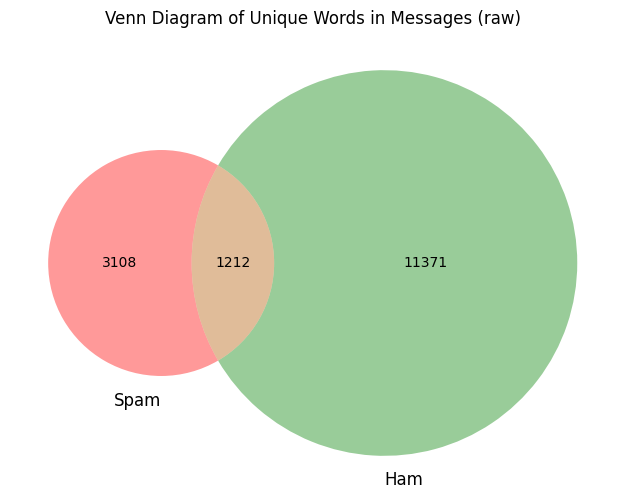

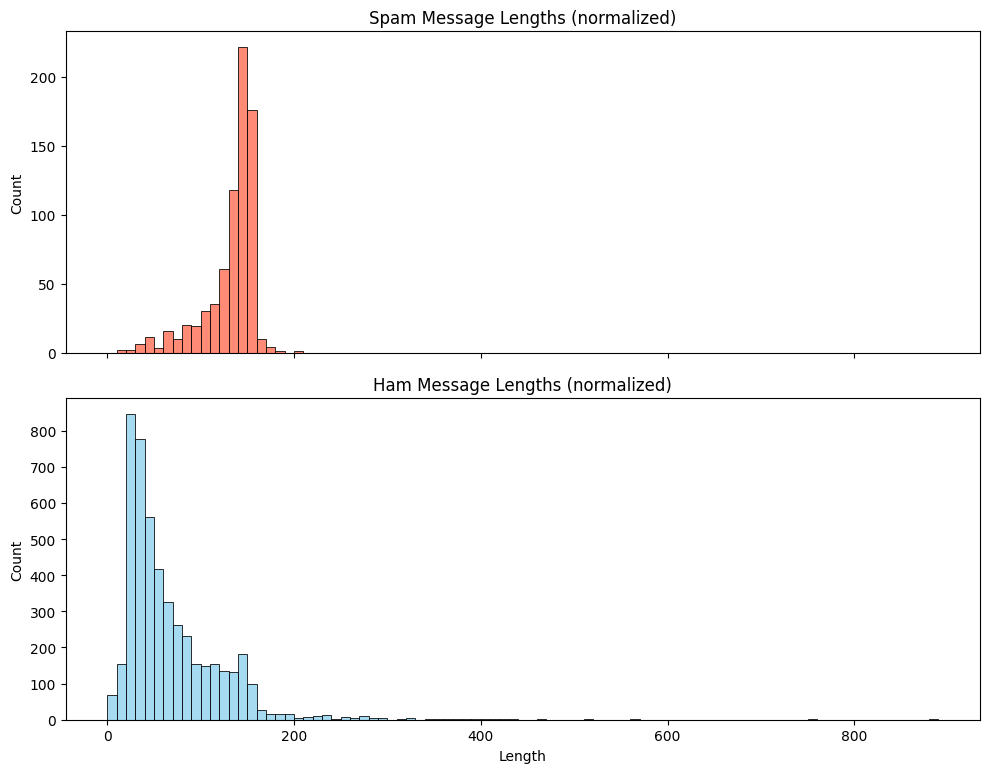

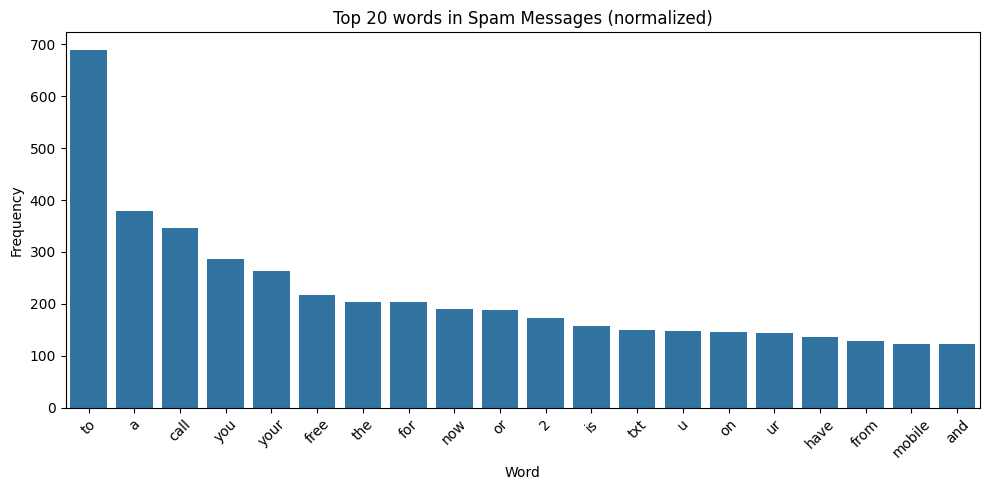

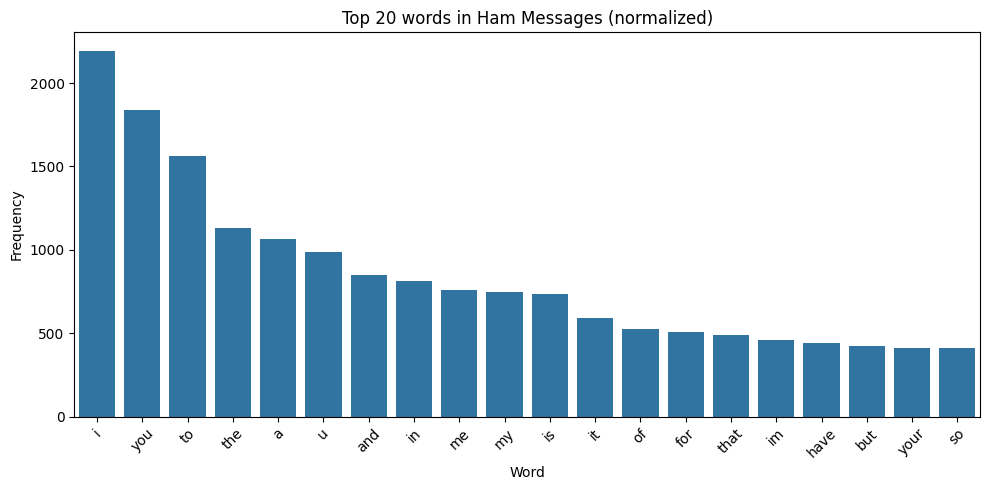

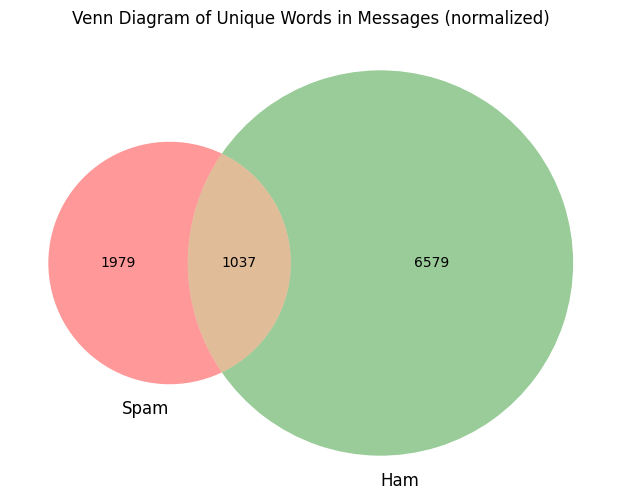

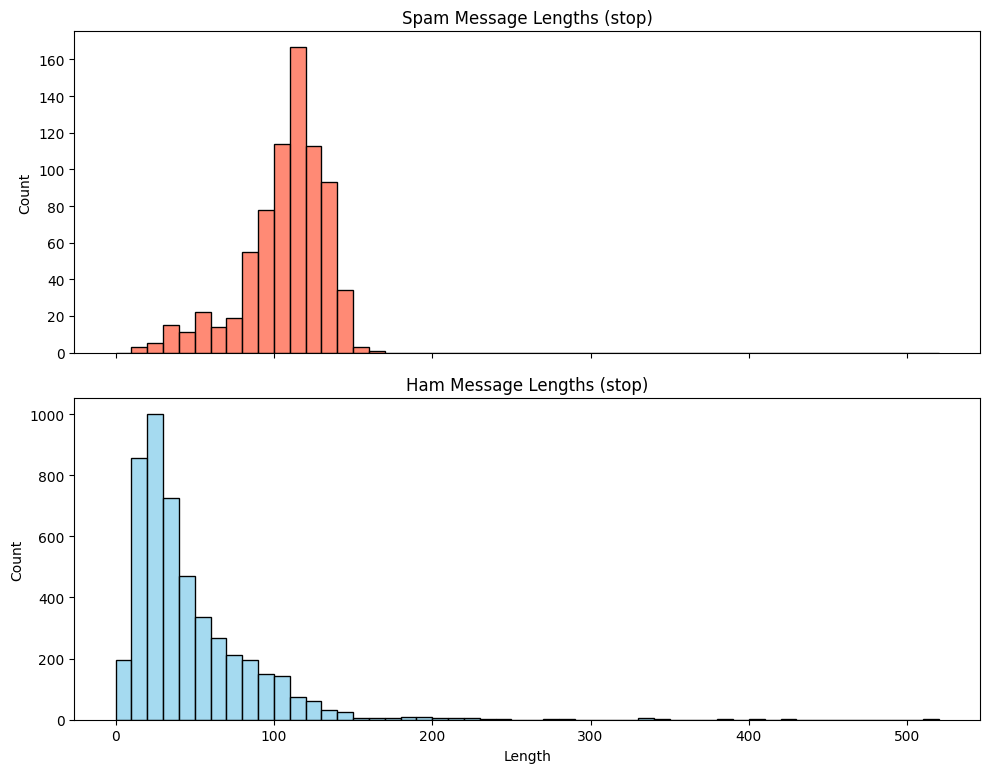

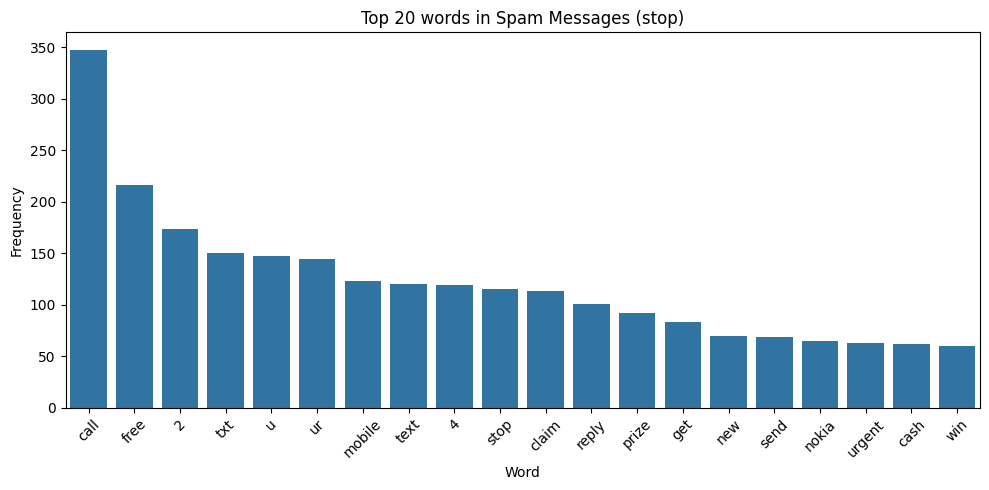

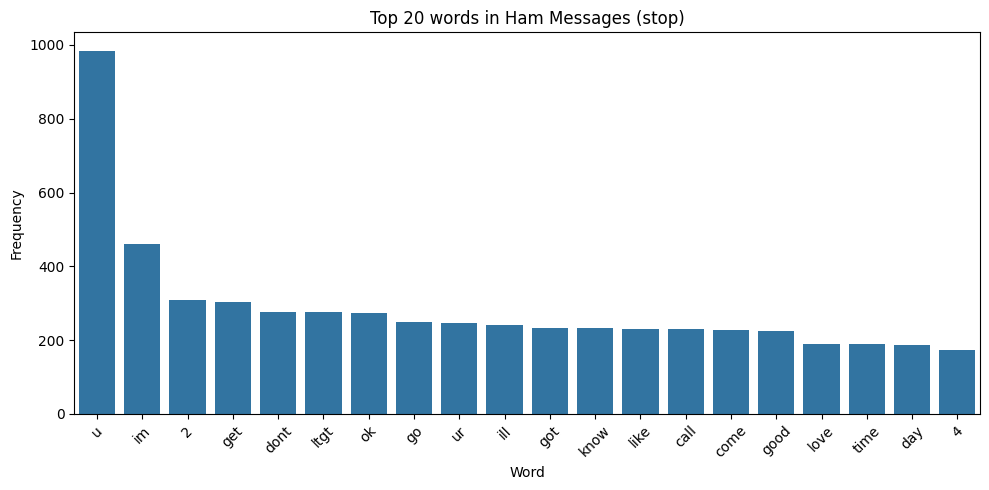

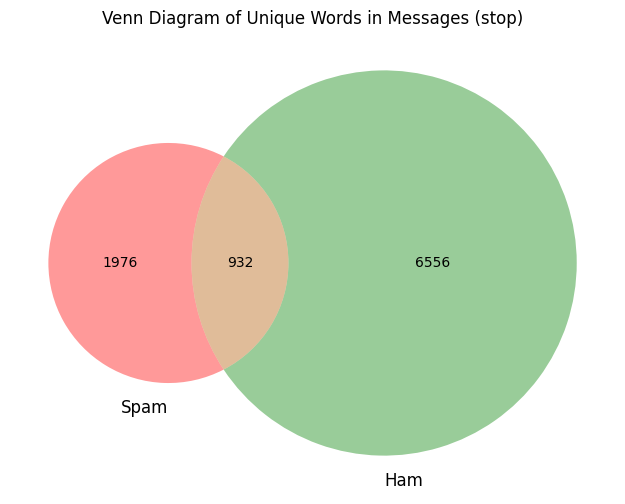

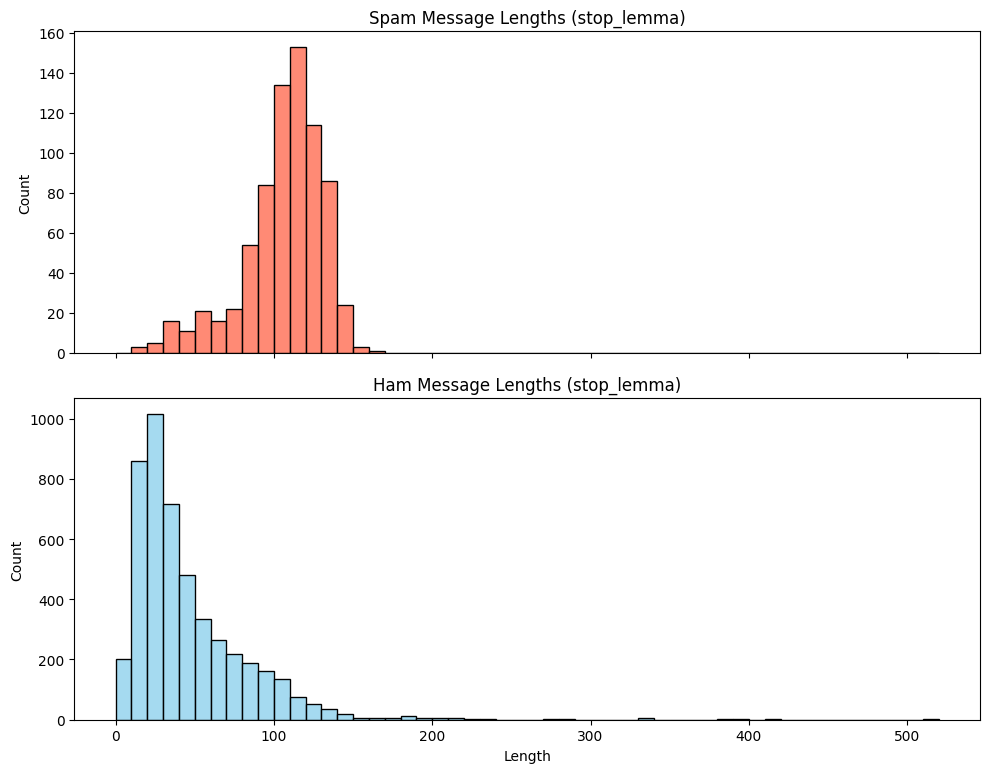

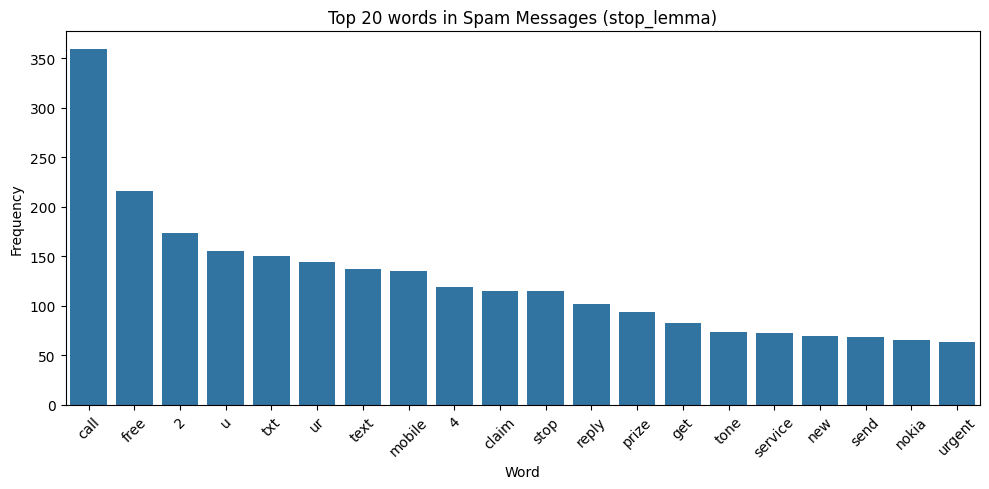

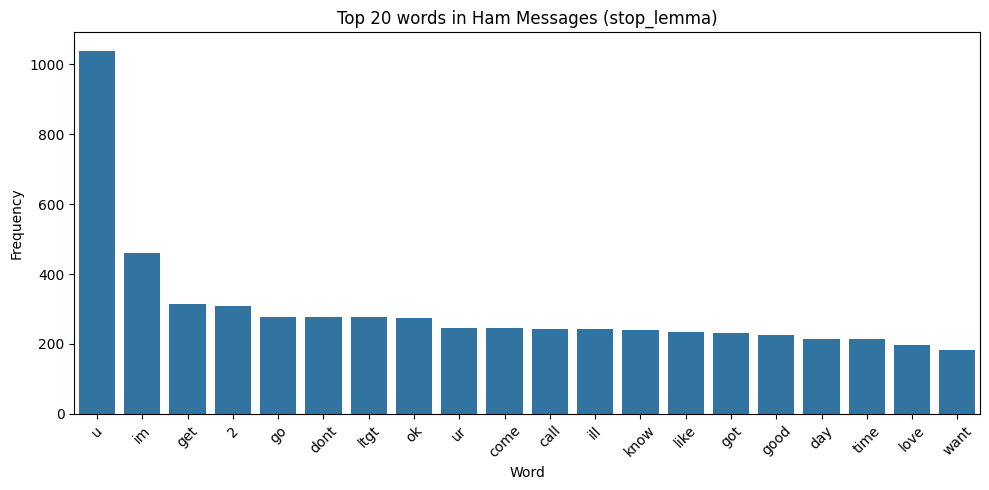

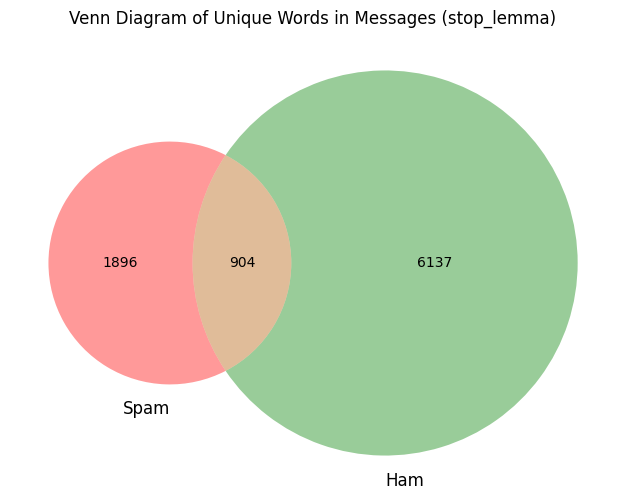

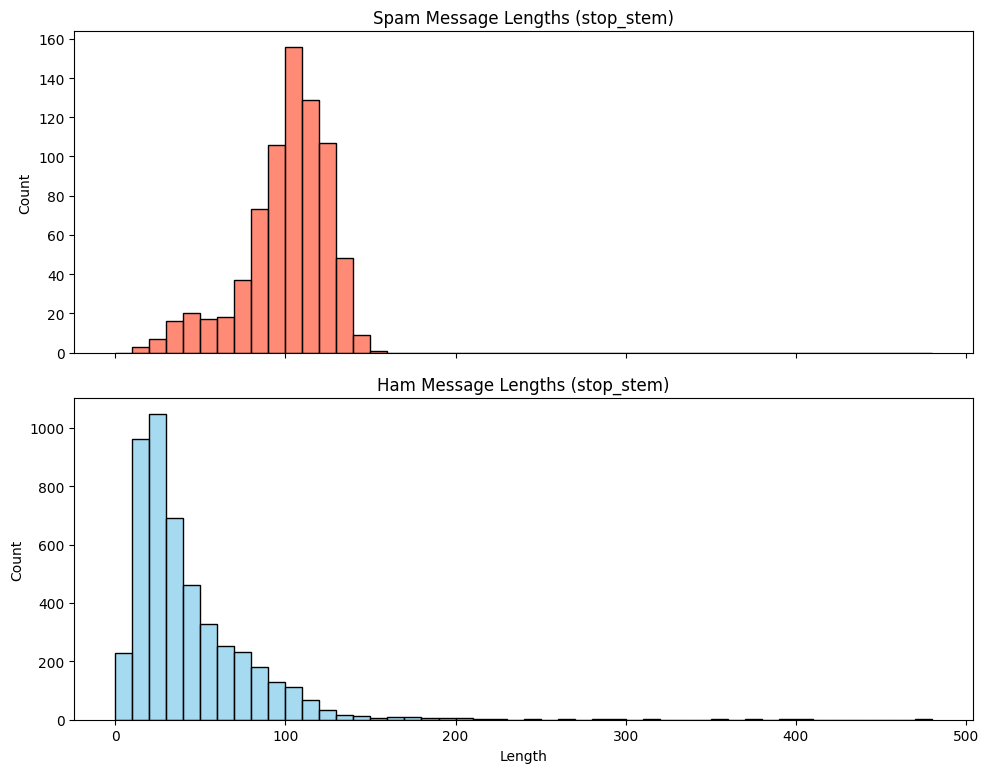

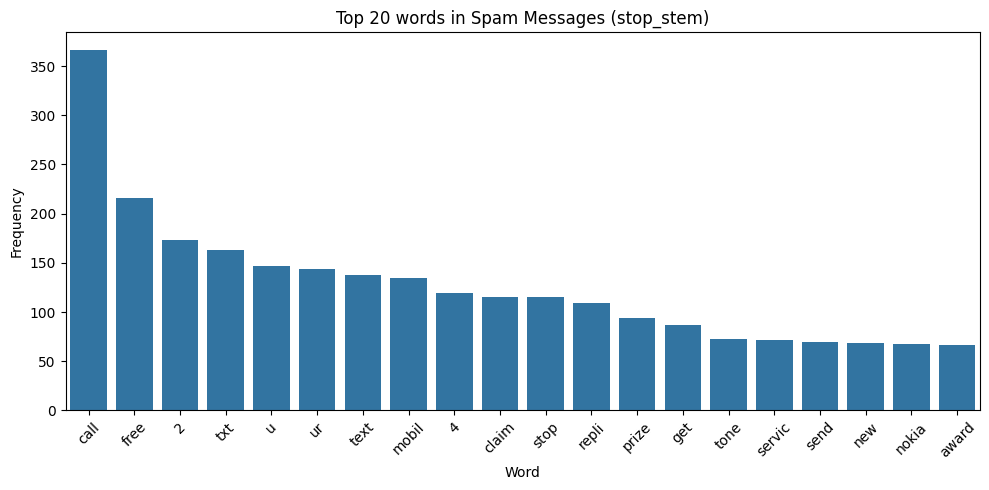

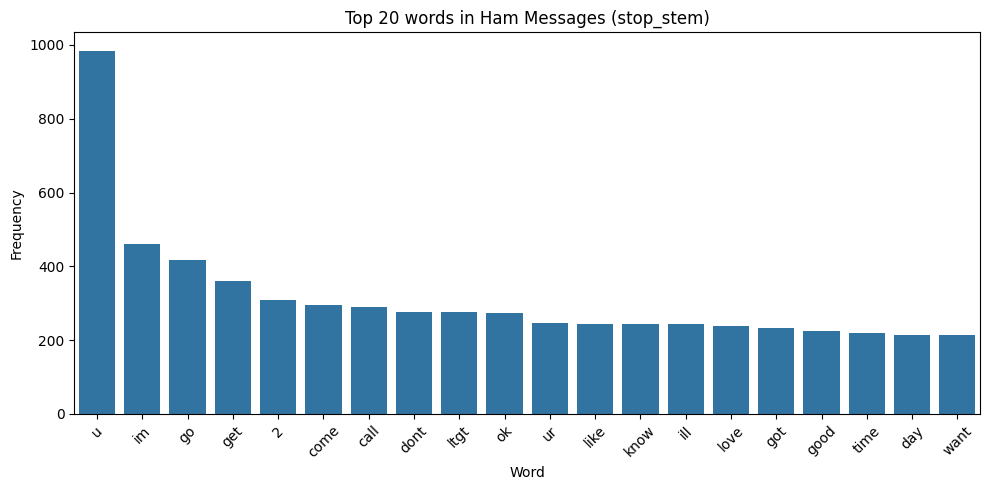

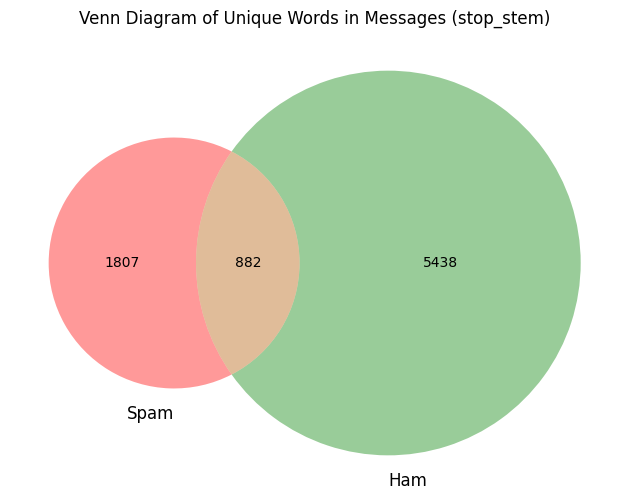

In [5]:
for variant in VARIANTS:
    plot_message_lengths(df, column=variant, label_column='label', title=variant, save_path=f'data/eda/{variant}/message_lengths.png')
    plot_top_words_by_class(df, column=variant, label_value='spam', top_n=20, title=f'Top 20 words in Spam Messages ({variant})',save_path=f'data/eda/{variant}/top_spam.png')
    plot_top_words_by_class(df, column=variant, label_value='ham', top_n=20, title=f'Top 20 words in Ham Messages ({variant})', save_path=f'data/eda/{variant}/top_ham.png')
    plot_venn_words(df, column=variant, title=f'Venn Diagram of Unique Words in Messages ({variant})', save_path=f'data/eda/{variant}/venn.png')


## Train/Evaluate Models

In [6]:
RANDOM_STATE = 202505

### Baseline

In [7]:
for variant in VARIANTS:
    print(variant)
    _, _, baseline_stats = run_baseline_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
    write_stats_to_csv(baseline_stats, f'data/stats.csv')

print('ham_as_spam')
for missed in baseline_stats['misclassified']['ham_as_spam'][:10]:
    print(missed)

print('spam_as_ham')
for missed in baseline_stats['misclassified']['spam_as_ham'][:10]:
    print(missed)



raw
Training Time: 0.0243 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       979
        Spam       0.99      0.72      0.83       136

    accuracy                           0.97      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.97      0.97      0.96      1115

Confusion Matrix:
[[978   1]
 [ 38  98]]
Saved confusion matrix to data/baseline/baseline_raw_cf.png
Saved ROC curve to data/baseline/baseline_raw_roc.png
normalized
Training Time: 0.0092 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       979
        Spam       0.99      0.69      0.81       136

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
[[978   1]
 [ 42  94]]
Saved confusion matrix to dat

### MNB

In [8]:
for variant in VARIANTS:
    print(variant)
    _, _, mnb_stats = run_multinomial_nb_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
    write_stats_to_csv(mnb_stats, f'data/stats.csv')

    print('ham_as_spam')
    for missed in mnb_stats['misclassified']['ham_as_spam'][:10]:
        print(missed)

    print('spam_as_ham')
    for missed in mnb_stats['misclassified']['spam_as_ham'][:10]:
        print(missed)

raw
Training Time: 0.0007 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       979
        Spam       1.00      0.72      0.84       136

    accuracy                           0.97      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.97      0.97      0.96      1115

Confusion Matrix:
[[979   0]
 [ 38  98]]
Saved confusion matrix to data/mnb/multinb_raw_cf.png
Saved ROC curve to data/mnb/mnb_raw_roc.png
ham_as_spam
spam_as_ham
3 FREE TAROT TEXTS! Find out about your love life now! TRY 3 FOR FREE! Text CHANCE to 85555 16 only! After 3 Free, Msgs £1.50 each
Good Luck! Draw takes place 28th Feb 06. Good Luck! For removal send STOP to 87239 customer services 08708034412
Thank you, winner notified by sms. Good Luck! No future marketing reply STOP to 84122 customer services 08450542832
Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p.

### LSTM

In [9]:
# for variant in VARIANTS:
#     print(variant)
#     _, _, lstm_stats = run_lstm_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
#     write_stats_to_csv(lstm_stats, f'data/stats.csv')

#     print('ham_as_spam')
#     for missed in mnb_stats['misclassified']['ham_as_spam'][:10]:
#         print(missed)

#     print('spam_as_ham')
#     for missed in mnb_stats['misclassified']['spam_as_ham'][:10]:
#         print(missed)

### BERT

In [10]:
for variant in VARIANTS:
    print(variant)
    _, _, mnb_stats = run_bert_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
    write_stats_to_csv(mnb_stats, f'data/stats.csv')

    print('ham_as_spam')
    for missed in mnb_stats['misclassified']['ham_as_spam'][:10]:
        print(missed)

    print('spam_as_ham')
    for missed in mnb_stats['misclassified']['spam_as_ham'][:10]:
        print(missed)

raw


Map: 100%|██████████| 1115/1115 [00:00<00:00, 27132.71 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0901, train accuracy = 0.9690, val accuracy = 0.9865
Epoch 2: avg training loss = 0.0306, train accuracy = 0.9890, val accuracy = 0.9892
Epoch 3: avg training loss = 0.0179, train accuracy = 0.9948, val accuracy = 0.9883
Epoch 4: avg training loss = 0.0091, train accuracy = 0.9984, val accuracy = 0.9901
Epoch 5: avg training loss = 0.0188, train accuracy = 0.9962, val accuracy = 0.9713
Epoch 6: avg training loss = 0.1530, train accuracy = 0.9601, val accuracy = 0.9758
Epoch 7: avg training loss = 0.1608, train accuracy = 0.9616, val accuracy = 0.9758
Early stopping triggered at epoch 7
Training Time: 200.5696 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       979
        Spam       0.99      0.81      0.89       136

    accuracy                           0.98      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.98      0.98      0.97      

Map: 100%|██████████| 1115/1115 [00:00<00:00, 29772.40 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.1036, train accuracy = 0.9646, val accuracy = 0.9821
Epoch 2: avg training loss = 0.0245, train accuracy = 0.9937, val accuracy = 0.9910
Epoch 3: avg training loss = 0.0129, train accuracy = 0.9962, val accuracy = 0.9883
Epoch 4: avg training loss = 0.0072, train accuracy = 0.9980, val accuracy = 0.9874
Epoch 5: avg training loss = 0.0070, train accuracy = 0.9980, val accuracy = 0.9910
Early stopping triggered at epoch 5
Training Time: 149.0273 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       979
        Spam       0.97      0.96      0.96       136

    accuracy                           0.99      1115
   macro avg       0.98      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Saved confusion matrix to data/bert/bert_normalized_cf.png
Saved ROC curve to data/bert/bert_normalized_roc.png
ham_as_spam
yun ahthe ubi one say if ü wan call by

Map: 100%|██████████| 1115/1115 [00:00<00:00, 34761.84 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0958, train accuracy = 0.9711, val accuracy = 0.9857
Epoch 2: avg training loss = 0.0392, train accuracy = 0.9892, val accuracy = 0.9874
Epoch 3: avg training loss = 0.0177, train accuracy = 0.9951, val accuracy = 0.9883
Epoch 4: avg training loss = 0.0116, train accuracy = 0.9969, val accuracy = 0.9901
Epoch 5: avg training loss = 0.0023, train accuracy = 0.9996, val accuracy = 0.9901
Epoch 6: avg training loss = 0.0001, train accuracy = 1.0000, val accuracy = 0.9901
Epoch 7: avg training loss = 0.0001, train accuracy = 1.0000, val accuracy = 0.9910
Epoch 8: avg training loss = 0.0000, train accuracy = 1.0000, val accuracy = 0.9910
Epoch 9: avg training loss = 0.0000, train accuracy = 1.0000, val accuracy = 0.9910
Epoch 10: avg training loss = 0.0000, train accuracy = 1.0000, val accuracy = 0.9910
Early stopping triggered at epoch 10
Training Time: 280.9236 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham

Map: 100%|██████████| 1115/1115 [00:00<00:00, 35961.50 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0946, train accuracy = 0.9722, val accuracy = 0.9883
Epoch 2: avg training loss = 0.0400, train accuracy = 0.9899, val accuracy = 0.9883
Epoch 3: avg training loss = 0.0234, train accuracy = 0.9939, val accuracy = 0.9892
Epoch 4: avg training loss = 0.0125, train accuracy = 0.9978, val accuracy = 0.9839
Epoch 5: avg training loss = 0.0105, train accuracy = 0.9984, val accuracy = 0.9901
Epoch 6: avg training loss = 0.0074, train accuracy = 0.9991, val accuracy = 0.9901
Epoch 7: avg training loss = 0.0077, train accuracy = 0.9991, val accuracy = 0.9919
Epoch 8: avg training loss = 0.0097, train accuracy = 0.9982, val accuracy = 0.9803
Epoch 9: avg training loss = 0.0215, train accuracy = 0.9955, val accuracy = 0.9874
Epoch 10: avg training loss = 0.0444, train accuracy = 0.9901, val accuracy = 0.9821
Early stopping triggered at epoch 10
Training Time: 274.2959 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham

Map: 100%|██████████| 1115/1115 [00:00<00:00, 32905.41 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.1011, train accuracy = 0.9702, val accuracy = 0.9821
Epoch 2: avg training loss = 0.0460, train accuracy = 0.9868, val accuracy = 0.9803
Epoch 3: avg training loss = 0.0477, train accuracy = 0.9879, val accuracy = 0.9803
Epoch 4: avg training loss = 0.0474, train accuracy = 0.9870, val accuracy = 0.9848
Epoch 5: avg training loss = 0.0176, train accuracy = 0.9962, val accuracy = 0.9892
Epoch 6: avg training loss = 0.0222, train accuracy = 0.9953, val accuracy = 0.9839
Epoch 7: avg training loss = 0.0115, train accuracy = 0.9982, val accuracy = 0.9857
Epoch 8: avg training loss = 0.0070, train accuracy = 0.9987, val accuracy = 0.9883
Early stopping triggered at epoch 8
Training Time: 241.7129 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       979
        Spam       0.98      0.92      0.95       136

    accuracy                           0.99      1115
   macro avg       